File: stock_prediction.py

Original Authors: Bao Vo and Cheong Koo

 Original Dates: 14/07/2021 (v1); 19/07/2021 (v2); 02/07/2024 (v3)

-----------------------------------------------------------------------
 Code adapted from:
  Title: Predicting Stock Prices with Python (NeuralNine)


   YouTube: https://www.youtube.com/watch?v=PuZY9q-aKLw
  Reference repo (tutorials by x4nth055 / The Python Code): see LICENSE in repo


------------------------------------------------------------------------
 Modifications: 
  Modified by: Suyogya “Rex” Raj Joshi

  Date: 28/08/2025

  Summary of changes: Switched to yfinance download, adjusted train/test dates,

  clarified scaling/reshaping comments, tweaked LSTM stack & dropout, added

  plotting, etc. (list your real changes briefly)

------------------------------------------------------------------------------------------------
License:

  Retain original license/notice from any borrowed sources. If you publish this

  project, include the upstream LICENSE files and attribution in your README.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer

In [ ]:
#------------------------------------------------------------------------------
# Load Data
## TO DO:
# 1) Check if data has been saved before. 
# If so, load the saved data
# If not, save the data into a directory
#------------------------------------------------------------------------------
# DATA_SOURCE = "yahoo" #Using yahoo finance for data source

COMPANY = 'AAPL' # Ticker for Apple stock

In [10]:
TRAIN_START = '2020-01-01'     # Start date to read
TRAIN_END = '2023-08-01'       # End date to read

data = web.DataReader(COMPANY, DATA_SOURCE, TRAIN_START, TRAIN_END) # Read data using yahoo

In [5]:
import yfinance as yf

In [ ]:
# Get the data for the stock AAPL
data = yf.download(COMPANY,TRAIN_START,TRAIN_END)
print("------------------------------------------------------------")
print(data.head()) #Printing the ordered data

C:\Users\raj23\AppData\Local\Temp\ipykernel_26672\1548533592.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(COMPANY,TRAIN_START,TRAIN_END)
[*********************100%***********************]  1 of 1 completed

------------------------------------------------------------
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.538521  72.598899  71.292311  71.545897  135480400
2020-01-03  71.833290  72.594055  71.608685  71.765667  146322800
2020-01-06  72.405678  72.444321  70.703012  70.954188  118387200
2020-01-07  72.065147  72.671341  71.845369  72.415337  108872000
2020-01-08  73.224396  73.526287  71.768071  71.768071  132079200


In [ ]:
import os
DATA_PATH = f"data/{COMPANY}_data.csv"

# Make sure "data" folder exists
os.makedirs("data", exist_ok=True)

# Checking cached data if exists, otherwise saving it.
if os.path.exists(DATA_PATH):
    print(" Loading saved data.")
    df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
else:
    print(" Downloading fresh data...")
    df = yf.download(COMPANY, TRAIN_START, TRAIN_END)
    df.to_csv(DATA_PATH)
    print(" Saved data to", DATA_PATH)

# Quick check
print(df.head(10)) # First 10 rows
print("---------------------------------------------------------------------")
print(df.tail(10)) # Last 10 rows
print("---------------------------------------------------------------------")
print(df.isna().sum()) # Checking NaN Or missing values.

 Loading saved data.
                        Close               High                Low  \
Price                                                                 
Ticker                   AAPL               AAPL               AAPL   
Date                      NaN                NaN                NaN   
2020-01-02  72.53850555419922  72.59888386623527  71.29229630932706   
2020-01-03  71.83329010009766  72.59405542623057  71.60868452797844   
2020-01-06  72.40567779541016  72.44432080433776   70.7030121336898   
2020-01-07  72.06513977050781  72.67133299565539  71.84536183598526   
2020-01-08  73.22441101074219  73.52630260685811  71.76808624589498   
2020-01-09  74.77975463867188  74.97296230565743   73.9513658951312   
2020-01-10  74.94882202148438  75.51396965111952  74.44647758118805   
2020-01-13  76.55005645751953  76.57662675415311  75.14686472001775   

                         Open     Volume  
Price                                     
Ticker                   AAPL       AAPL

C:\Users\raj23\AppData\Local\Temp\ipykernel_26672\3127552139.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)


In [8]:
#------------------------------------------------------------------------------
# Prepare Data
## To do:
# 1) Check if data has been prepared before. 
# If so, load the saved data
# If not, save the data into a directory
# 2) Use a different price value eg. mid-point of Open & Close
# 3) Change the Prediction days
#------------------------------------------------------------------------------
PRICE_VALUE = "Close"

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
# Note that, by default, feature_range=(0, 1). Thus, if you want a different 
# feature_range (min,max) then you'll need to specify it here
scaled_data = scaler.fit_transform(data[PRICE_VALUE].values.reshape(-1, 1)) 
# Flatten and normalise the data
# First, we reshape a 1D array(n) to 2D array(n,1)
# We have to do that because sklearn.preprocessing.fit_transform()
# requires a 2D array
# Here n == len(scaled_data)
# Then, we scale the whole array to the range (0,1)
# The parameter -1 allows (np.)reshape to figure out the array size n automatically 
# values.reshape(-1, 1) 
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape'
# When reshaping an array, the new shape must contain the same number of elements 
# as the old shape, meaning the products of the two shapes' dimensions must be equal. 
# When using a -1, the dimension corresponding to the -1 will be the product of 
# the dimensions of the original array divided by the product of the dimensions 
# given to reshape so as to maintain the same number of elements.

In [10]:
# Number of days to look back to base the prediction
PREDICTION_DAYS = 60 # Original

In [11]:
# To store the training data
x_train = []
y_train = []

In [12]:
scaled_data = scaled_data[:,0] # Turn the 2D array back to a 1D array
# Prepare the data
for x in range(PREDICTION_DAYS, len(scaled_data)):
    x_train.append(scaled_data[x-PREDICTION_DAYS:x])
    y_train.append(scaled_data[x])

In [13]:
# Convert them into an array
x_train, y_train = np.array(x_train), np.array(y_train)
# Now, x_train is a 2D array(p,q) where p = len(scaled_data) - PREDICTION_DAYS
# and q = PREDICTION_DAYS; while y_train is a 1D array(p)

In [14]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# We now reshape x_train into a 3D array(p, q, 1); Note that x_train 
# is an array of p inputs with each input being a 2D array 

In [15]:
#------------------------------------------------------------------------------
# Build the Model
## TO DO:
# 1) Check if data has been built before. 
# If so, load the saved data
# If not, save the data into a directory
# 2) Change the model to increase accuracy?
#------------------------------------------------------------------------------
model = Sequential() # Basic neural network
# See: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
# for some useful examples

In [16]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# This is our first hidden layer which also spcifies an input layer. 
# That's why we specify the input shape for this layer; 
# i.e. the format of each training example
# The above would be equivalent to the following two lines of code:
# model.add(InputLayer(input_shape=(x_train.shape[1], 1)))
# model.add(LSTM(units=50, return_sequences=True))
# For som eadvances explanation of return_sequences:
# https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
# https://www.dlology.com/blog/how-to-use-return_state-or-return_sequences-in-keras/
# As explained there, for a stacked LSTM, you must set return_sequences=True 
# when stacking LSTM layers so that the next LSTM layer has a 
# three-dimensional sequence input. 

c:\Users\raj23\Documents\GitHub\COS_30018_105098233_Optioin_3\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Finally, units specifies the number of nodes in this layer.
This is one of the parameters you want to play with to see what number
of units will give you better prediction quality (for your problem)

In [17]:
model.add(Dropout(0.2))
# The Dropout layer randomly sets input units to 0 with a frequency of 
# rate (= 0.2 above) at each step during training time, which helps 
# prevent overfitting (one of the major problems of ML). 

In [18]:
model.add(LSTM(units=50, return_sequences=True))
# More on Stacked LSTM:
# https://machinelearningmastery.com/stacked-long-short-term-memory-networks/

In [19]:
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

In [20]:
model.add(Dense(units=1)) 
# Prediction of the next closing value of the stock price

In [21]:
# We compile the model by specify the parameters for the model
# See lecture Week 6 (COS30018)
model.compile(optimizer='adam', loss='mean_squared_error')
# The optimizer and loss are two important parameters when building an 
# ANN model. Choosing a different optimizer/loss can affect the prediction
# quality significantly. You should try other settings to learn; e.g.

optimizer='rmsprop'/'sgd'/'adadelta'/...
loss='mean_absolute_error'/'huber_loss'/'cosine_similarity'/...

In [22]:
# Now we are going to train this model with our training data 
# (x_train, y_train)
model.fit(x_train, y_train, epochs=25, batch_size=32)
# Other parameters to consider: How many rounds(epochs) are we going to 
# train our model? Typically, the more the better, but be careful about
# overfitting!
# What about batch_size? Well, again, please refer to 
# Lecture Week 6 (COS30018): If you update your model for each and every 
# input sample, then there are potentially 2 issues: 1. If you training 
# data is very big (billions of input samples) then it will take VERY long;
# 2. Each and every input can immediately makes changes to your model
# (a souce of overfitting). Thus, we do this in batches: We'll look at
# the aggreated errors/losses from a batch of, say, 32 input samples
# and update our model based on this aggregated loss.

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0970
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0129
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0083
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0083
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0081
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0069
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0071
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0084
Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0064
Epoch 10/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0061
Epoch 11/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0064
Epoch 12/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0064
Epoch 13/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0060
Epoch 14/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0055
Epoch 15/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0057
Epoc

TO DO:
Save the model and reload it
Sometimes, it takes a lot of effort to train your model (again, look at
a training data with billions of input samples). Thus, after spending so 
much computing power to train your model, you may want to save it so that
in the future, when you want to make the prediction, you only need to load
your pre-trained model and run it on the new input for which the prediction
need to be made.

In [23]:
#------------------------------------------------------------------------------
# Test the model accuracy on existing data
#------------------------------------------------------------------------------
# Load the test data
TEST_START = '2023-08-02'
TEST_END = '2024-07-02'

test_data = web.DataReader(COMPANY, DATA_SOURCE, TEST_START, TEST_END)

In [24]:
test_data = yf.download(COMPANY,TEST_START,TEST_END)

C:\Users\raj23\AppData\Local\Temp\ipykernel_33336\448349976.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_data = yf.download(COMPANY,TEST_START,TEST_END)
[*********************100%***********************]  1 of 1 completed


The above bug is the reason for the following line of code
test_data = test_data[1:]

In [25]:
actual_prices = test_data[PRICE_VALUE].values

In [26]:
total_dataset = pd.concat((data[PRICE_VALUE], test_data[PRICE_VALUE]), axis=0)

In [27]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - PREDICTION_DAYS:].values
# We need to do the above because to predict the closing price of the fisrt
# PREDICTION_DAYS of the test period [TEST_START, TEST_END], we'll need the 
# data from the training period

In [28]:
model_inputs = model_inputs.reshape(-1, 1)
# TO DO: Explain the above line

In [29]:
model_inputs = scaler.transform(model_inputs)
# We again normalize our closing price data to fit them into the range (0,1)
# using the same scaler used above 
# However, there may be a problem: scaler was computed on the basis of
# the Max/Min of the stock price for the period [TRAIN_START, TRAIN_END],
# but there may be a lower/higher price during the test period 
# [TEST_START, TEST_END]. That can lead to out-of-bound values (negative and
# greater than one)
# We'll call this ISSUE #2

TO DO: Generally, there is a better way to process the data so that we 
can use part of it for training and the rest for testing. You need to 
implement such a way

In [30]:
#------------------------------------------------------------------------------
# Make predictions on test data
#------------------------------------------------------------------------------
x_test = []
for x in range(PREDICTION_DAYS, len(model_inputs)):
    x_test.append(model_inputs[x - PREDICTION_DAYS:x, 0])

In [31]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# TO DO: Explain the above 5 lines

In [32]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
# Clearly, as we transform our data into the normalized range (0,1),
# we now need to reverse this transformation 
#------------------------------------------------------------------------------
# Plot the test predictions
## To do:
# 1) Candle stick charts
# 2) Chart showing High & Lows of the day
# 3) Show chart of next few days (predicted)
#------------------------------------------------------------------------------

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


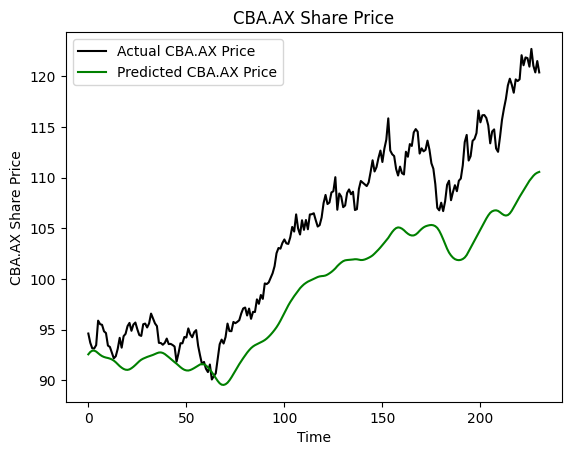

In [33]:
plt.plot(actual_prices, color="black", label=f"Actual {COMPANY} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {COMPANY} Price")
plt.title(f"{COMPANY} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{COMPANY} Share Price")
plt.legend()
plt.show()

------------------------------------------------------------------------------
Predict next day
------------------------------------------------------------------------------

In [34]:
real_data = [model_inputs[len(model_inputs) - PREDICTION_DAYS:, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [35]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Prediction: [[110.582214]]


A few concluding remarks here:
1. The predictor is quite bad, especially if you look at the next day 
prediction, it missed the actual price by about 10%-13%
Can you find the reason?
2. The code base at
https://github.com/x4nth055/pythoncode-tutorials/tree/master/machine-learning/stock-prediction
gives a much better prediction. Even though on the surface, it didn't seem 
to be a big difference (both use Stacked LSTM)
Again, can you explain it?
A more advanced and quite different technique use CNN to analyse the images
of the stock price changes to detect some patterns with the trend of
the stock price:
https://github.com/jason887/Using-Deep-Learning-Neural-Networks-and-Candlestick-Chart-Representation-to-Predict-Stock-Market
Can you combine these different techniques for a better prediction??